## Logistic regression classifier (with Neural Network Mindset) for Image classification

This script recognize Lithostratigraphic Chart amoung images from 5 geological iamge classes

### Data: dataset_for_lithochart_vs_all_Other_Classes.hdf5 (see the script Data Conversion to HDF5 Format_Lithostratigraphic Chart Vs ALL)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
%matplotlib inline

In [4]:
    # Loading dataset created by the script "dataset_for_lithochart_vs_all_Other_Classes.hdf5"
    
    train_dataset = h5py.File('AllGeoImages/dataset_for_lithochart_vs_all_Other_Classes.hdf5', "r")
    train_set_x_orig = np.array(train_dataset["train_img"][:])      # training Images
    train_set_y_orig = np.array(train_dataset["train_labels"][:])   # training Labels

    test_dataset = h5py.File('AllGeoImages/dataset_for_lithochart_vs_all_Other_Classes.hdf5', "r")
    test_set_x_orig = np.array(test_dataset["test_img"][:])         # test Images
    test_set_y_orig = np.array(test_dataset["test_labels"][:])      # test Labels

    classes =np.array([b'Lithostratigraphic Chart',b'Other Geological Image'],dtype='|S25')
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))


y = [1], it's a 'Other Geological Image' picture.


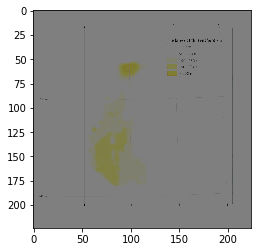

In [5]:
# Example of a picture
index = 56
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y_orig[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y_orig[:, index])].decode("utf-8") +  "' picture.")

In [6]:
# Train_set_x_orig is a numpy-array of shape (m_train, num_px, num_px, 3)
    # - m_train (number of training examples)
    # - m_test (number of test examples)
    # - num_px (= height = width of a training image)
    
train_set_y=train_set_y_orig
test_set_y=test_set_y_orig
m_train = train_set_x_orig.shape [0]
m_test = test_set_x_orig.shape [0]
num_px = train_set_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 169
Number of testing examples: m_test = 57
Height/Width of each image: num_px = 224
Each image is of size: (224, 224, 3)
train_set_x shape: (169, 224, 224, 3)
train_set_y shape: (1, 169)
test_set_x shape: (57, 224, 224, 3)
test_set_y shape: (1, 57)


In [7]:
# Reshaping the training and test data sets so that images of size (num_px, num_px, 3) are flattened into single vectors of shape (num_px ∗ num_px ∗3, 1)

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape (num_px*num_px*3, test_set_x_orig.shape [0])

In [8]:
# Standardize our dataset
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

## General Architecture of the learning algorithm ##

Logistic Regression, using a Neural Network mindset to distinguish Lithostratigraphic Charts from other other geological Images.

<img src="AllGeoImages/Illustration.png" style="width:650px;height:400px;">

**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**Workflow**:
    - Initialize the parameters of the model
    - Learn the parameters for the model by minimizing the cost  
    - Use the learned parameters to make predictions (on the test set)
    - Analyse the results and conclude

## Hardway Implementation (through Function)

In [9]:

# FUNCTION 1: Helper function : Sigmoid
def sigmoid(z):
    """ Compute the sigmoid of z
    Arguments:
    z -- A scalar or numpy array of any size.
    Return:
    s -- sigmoid(z)
    """

    s = 1/(1+ np.exp(-z))
    
    return s
print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))


# FUNCTION 2: initializing parameters
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    w = np.zeros((dim,1))
    b = 0

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

sigmoid([0, 2]) = [0.5        0.88079708]


### Forward and Backward propagation

"Forward" and "backward" propagation steps for learning the parameters

Workflow:
- get X
- compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- Calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$


$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [10]:
# FUNCTION 3: Propagation
def propagate(w, b, X, Y):
    """
    Implementation of a cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    """
    
    m = X.shape[1]
    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid (np.dot(w.T,X)+b)                               # compute activation
    cost = (-1/m)*(np.sum((np.multiply(Y, np.log(A)))+ np.multiply((1-Y),np.log(1-A))))                                 # compute cost
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
   
    dw = (1/m)*(np.dot(X,(A-Y).T))
    db = (1/m)*np.sum(A-Y)
  

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost


### Optimization
Optimization function to update the parameters using gradient descent.
The goal is to learn $w$ and $b$ by minimizing the cost function $J$. For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [11]:
# FUNCTION 4: optimize

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Cost and gradient calculation 
        grads, cost = propagate(w, b, X, Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule
        w = w -learning_rate*dw
        b = b - learning_rate*db
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [12]:
# FUNCTION 5: Predict
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.dot(w.T,X)+b)
 
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        
        if A[0,i] <= 0.5: 
            Y_prediction[0,i] = 0
        else:
            Y_prediction[0,i] = 1
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

## Merge all functions into a model
Putting together all the building blocks (functions implemented in the previous parts) together, in the right order.

Implementation of the model function
    - Y_prediction_test for predictions on the test set
    - Y_prediction_train for predictions on the train set
    - w, costs, grads for the outputs of optimize()

In [20]:
# FUNCTION 6: model

def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost = False)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test =predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)



    # Print train/test Errors
    print("Train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("Test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_train, 
         "Y_prediction_train" : Y_prediction_test, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [18]:
model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 10000, learning_rate = 0.0001, print_cost =False)

Train accuracy: 97.0414201183432 %
Test accuracy: 77.19298245614036 %


{'costs': [0.6931471805599453,
  0.5009129879393522,
  0.490327819625116,
  0.4804160317283195,
  0.47108509579973573,
  0.46226147500163967,
  0.4538858939170809,
  0.4459099167068676,
  0.438293448594686,
  0.4310028928944358,
  0.4240097770748817,
  0.41728971735702775,
  0.41082162992020194,
  0.40458712347007436,
  0.3985700264750379,
  0.39275601537091487,
  0.3871323192022027,
  0.38168748268733954,
  0.37641117436730853,
  0.3712940298707352,
  0.3663275227839147,
  0.3615038574150066,
  0.35681587907259327,
  0.35225699847038733,
  0.34782112761460465,
  0.34350262509419033,
  0.3392962491245329,
  0.3351971170264044,
  0.33120067007872134,
  0.32730264288469546,
  0.3234990365491996,
  0.31978609509077544,
  0.3161602846123139,
  0.31261827483508287,
  0.3091569226664382,
  0.3057732575247091,
  0.3024644681885856,
  0.29922789097408276,
  0.2960609990721217,
  0.2929613929041605,
  0.28992679137422306,
  0.2869550239126306,
  0.28404402322140326,
  0.2811918186434282,
  0.27

In [21]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

NameError: name 'd' is not defined

In [ ]:
# Choice of learning rate
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()